# eBOSS 22 systematics study

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import fitsio as ft
import healpy as hp
import numpy as np
from glob import glob

# PATHS to my storage
# mehdi  @ cori
# rezaie @ OU iMac
HOME    = os.getenv('HOME')
USER    = os.getenv('USER')
sys.path.append(HOME + '/github/DESILSS')
dirs    = dict(rezaie='/Volumes/TimeMachine/data/', mehdi='/global/cscratch1/sd/mehdi/')
scratch = dirs[USER]
print('home is {}'.format(HOME))

home is /Users/rezaie


## DATA
### Original eBOSS 22 datafile from Arnaud

In [3]:
def nanomaggiesToMag(nm):
    return -2.5 * (np.log10(nm) - 9.)

In [4]:
d,header = ft.read(scratch + 'eboss/eBOSS_DR7/ELG_hpsyst.density.nside256.eboss22.fits', header=True)
for di in d.dtype.names:print('{} '.format(di), end=' ')
header    

hpind  hpra  hpdec  hpgaiastardens  hpebv  hpnobs_g  hpnobs_r  hpnobs_z  hppsfdepth_g  hppsfdepth_r  hppsfdepth_z  hpgaldepth_g  hpgaldepth_r  hpgaldepth_z  hppsfsize_g  hppsfsize_r  hppsfsize_z  hpweight_lin  random_photo  density_photo  NGC  SGC  eboss21  eboss22  eboss23  eboss25  


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                  166 / length of dimension 1
NAXIS2  =               786432 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                   26 / number of table fields
TTYPE1  = 'hpind   '           / Healpix index,nside=256,nested=False
TFORM1  = 'K       '
TTYPE2  = 'hpra    '           / Healpix right ascension in J2000 coordinates
TFORM2  = 'D       '
TUNIT2  = 'deg^-2  '
TTYPE3  = 'hpdec   '           / Healpix declination in J2000 coordinates
TFORM3  = 'D       '
TUNIT3  = 'deg^-2  '
TTYPE4  = 'hpgaiastardens'     / Healpix Gaia stellar density
TFORM4  = 'D       '
TUNIT4  = 'deg^-2  '
TTYPE5  = 'hpebv   '           / Healpix SFD extinction E(B-V)
TFORM5  = 'D       '
TUNIT5  = 'mag     '
TTYPE6  = 'hpnobs_g'  

# phot. maps to be regressed on : 
 17 ['hpgaiastardens', 'hpebv', 'hppsfdepth_r', 'hppsfdepth_g', 'hppsfdepth_z', 'hpgaldepth_r', 'hpgaldepth_g', 'hpgaldepth_z', 'hppsfsize_r', 'hppsfsize_g', 'hppsfsize_z', 'hpnobs_r', 'hpnobs_g', 'hpnobs_z', 'hpgaldepth_rg', 'hpgaldepth_rz', 'hpgaldepth_gz']
hppsfsize_r is fixed
hppsfsize_g is fixed
hppsfsize_z is fixed
sys hpgaiastardens :  mean :    446.362, std:    98.905
sys hpebv          :  mean :      0.034, std:     0.016
sys hppsfdepth_r   :  mean :   2073.811, std:  1167.782
sys hppsfdepth_g   :  mean :   2643.799, std:  1841.580
sys hppsfdepth_z   :  mean :    236.420, std:   193.237
sys hpgaldepth_r   :  mean :   1130.868, std:   591.094
sys hpgaldepth_g   :  mean :   1666.482, std:  1069.887
sys hpgaldepth_z   :  mean :    116.833, std:    89.619
sys hppsfsize_r    :  mean :      1.263, std:     0.099
sys hppsfsize_g    :  mean :      1.554, std:     0.126
sys hppsfsize_z    :  mean :      1.135, std:     0.085
sys hpnobs_r       :  mean

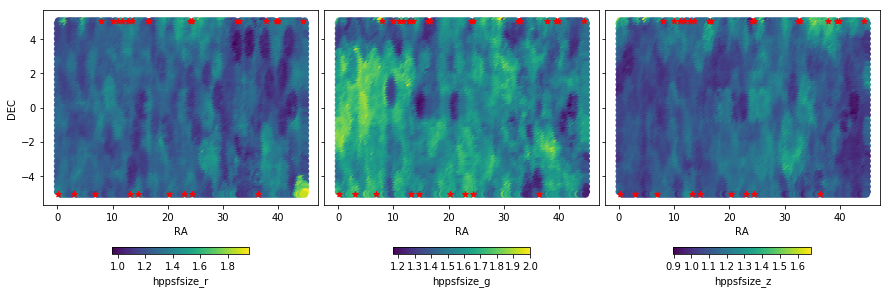

In [5]:
# add additional features DEC 27 : nobs, difference in depths
features = ['hpgaiastardens', 'hpebv'] \
         + [s+'_'+b for s in ['hppsfdepth', 'hpgaldepth', 'hppsfsize', 'hpnobs'] for b in 'rgz']\
         + ['hpgaldepth_rg', 'hpgaldepth_rz', 'hpgaldepth_gz']
print('# phot. maps to be regressed on : \n {} {}'.format(len(features), features))



#
# Prepare the data for the NN
#
# eboss MASK
mask     = d['eboss22'].astype('bool')
hpix     = d['hpind'][mask]
label    = d['density_photo'][mask]
data = np.zeros(label.size, dtype=np.dtype([('label', 'f8'), ('features', ('f8',len(features))),\
                                            ('hpix', 'i8'), ('fracgood', 'f8')]))


Features = []
for f in features[:-3]: # the last three are difference in depths
    Features.append(d[f][mask])
    
# add on DEC 27: difference in depths
Features.append(nanomaggiesToMag(d['hpgaldepth_r'][mask]) -nanomaggiesToMag(d['hpgaldepth_g'][mask]))
Features.append(nanomaggiesToMag(d['hpgaldepth_r'][mask]) -nanomaggiesToMag(d['hpgaldepth_z'][mask]))
Features.append(nanomaggiesToMag(d['hpgaldepth_g'][mask]) -nanomaggiesToMag(d['hpgaldepth_z'][mask]))
Features = np.column_stack(Features)

# fill in the NaN points
means = np.nanmean(Features, axis=0)
for i in range(Features.shape[1]):
    if (np.isnan(Features[:,i])).sum() !=0:
        print(features[i], 'is fixed')
        nanarg = np.isnan(Features[:,i])
        Features[nanarg, i] = means[i].copy()
        

data['features'] = Features
data['hpix']     = hpix
data['fracgood'] = np.ones_like(hpix)
data['label']    = label

# # Look at the mean and std of features
# #
for m in range(Features.shape[1]):
    print('sys {:15s}:  mean :   {:8.3f}, std:  {:8.3f}'\
          .format(features[m], np.mean(data['features'][:,m]),\
                  np.std(data['features'][:, m])))  

bands= ['r','g', 'z']
f,ax = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
plt.subplots_adjust(wspace=0.02, top=.9)
for i in range(3):
    name = 'hppsfsize_'+bands[i]    
    masknan = np.isnan(d[name])  & mask
    m1 = ax[i].scatter(d['hpra'][mask], d['hpdec'][mask], c=d[name][mask])
    ax[i].scatter(d['hpra'][masknan], d['hpdec'][masknan], c='red', marker='*')
    cb = f.colorbar(m1, ax=ax[i], shrink=0.5, orientation='horizontal')
    cb.set_label(name)
    ax[i].set_xlabel('RA')
    ax[0].set_ylabel('DEC')    
    
    
# average of labels

# NANmask = np.isnan(d['hppsfsize_r']) & mask
# centers = np.argwhere(NANmask).flatten()
# indices = hp.get_all_neighbours(256, centers)
# for i in range(indices.shape[1]):
#     print(centers[i], np.nanmean(d['hppsfsize_r'][indices[:,i]]))                                


# header=dict(features='hpgaiastardens, hpebv, hppsfdepth, hpgaldepth, hppsfsize, hpnobs  rgz',
#             fracgood='fracgood',  hpix='hpix with nside 256', label='density_photo')
# #ft.write(scratch + 'eboss/eBOSS_DR7/ngal.features.256.fits', data, header=header)
# ft.write(scratch + 'eboss/eBOSS_DR7/ngal.features.256.fits', data, header=header) # DEC 27: new features

# from split_data import split2Kfolds
# data5fold = split2Kfolds(data)
# np.save(scratch + 'eboss/eBOSS_DR7/ngal.features.256.5r', data5fold)
# hp.write_map(scratch + 'eboss/eBOSS_DR7/hpmask.256.fits',   d['eboss22'], fits_IDL=False)
# hp.write_map(scratch + 'eboss/eBOSS_DR7/eBOSSDR7.256.fits', d['density_photo']*d['random_photo'], fits_IDL=False)
# hp.write_map(scratch + 'eboss/eBOSS_DR7/random.256.fits',   d['random_photo'], fits_IDL=False)
# linw = 1/d['hpweight_lin']
# masklinw = (np.isnan(linw) & d['eboss22'])
# linw[masklinw] = 1.0
# hp.write_map(scratch + 'eboss/eBOSS_DR7/regression/lin-weights.hp256.fits',   linw, fits_IDL=False, overwrite=True)

### ADD new features
#### Add $\Delta E(B-V)$ as new feature
Look into ebv-ebvn

('label', 'features', 'hpix', 'fracgood')


([], <a list of 0 Text yticklabel objects>)

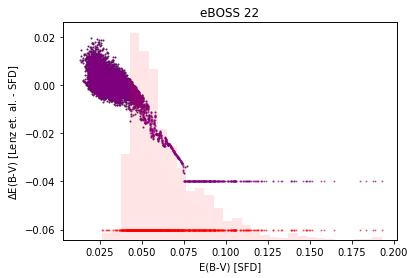

In [3]:
ebvg = ft.read(scratch + 'ebv_lhd.hpx.fits')['EBV']
feats = ft.read(scratch + 'eboss/eBOSS_DR7/ngal.features.256.jan4.fits')
print(feats.dtype.names)


thph = hp.pix2ang(256, feats['hpix'])
r = hp.Rotator(coord=['C', 'G'])
thphg = r(thph[0], thph[1])
hpix  = hp.ang2pix(1024, thphg[0], thphg[1])
from scipy.interpolate import InterpolatedUnivariateSpline as IUS




nan = np.isnan(ebvg[hpix])
debvd = np.zeros((~nan).sum(), dtype=[('ebv','f8'), ('devb', 'f8')])
debvd['ebv']  = feats['features'][~nan,1]
debvd['devb'] = ebvg[hpix][~nan]-feats['features'][~nan,1]
debvs = np.sort(debvd, order='ebv')
Debv = IUS(debvs['ebv'], debvs['devb'], k=1)


def DEBV(ebv):
    rs = np.zeros_like(ebv)
    m  = ebv >0.075 
    rs[m]  = -0.04
    rs[~m] = Debv(ebv[~m])
    return rs

debv = np.zeros(feats['features'].shape[0])
debv[~nan] = ebvg[hpix][~nan]-feats['features'][~nan,1]
debv[nan]  = DEBV(feats['features'][nan,1])

plt.title('eBOSS 22')
plt.scatter(feats['features'][~nan,1], ebvg[hpix][~nan]-feats['features'][~nan,1], 
            1.0, c='k', alpha=0.5)
plt.scatter(feats['features'][nan,1], -0.06*np.ones(nan.sum()),1.0, c='r', alpha=0.5)
plt.scatter(feats['features'][:,1], debv,1., c='purple', alpha=0.5)
plt.ylabel(r'$\Delta$E(B-V) [Lenz et. al. - SFD] ')
plt.xlabel('E(B-V) [SFD]')
plt.twinx()
plt.hist(feats['features'][nan,1],  alpha=0.1, color='r', bins=30)
plt.yticks([])

# Jan 10 HAS this
# data = np.zeros(feats['label'].size, dtype=np.dtype([('label', 'f8'), ('features', ('f8',18)),\
#                                             ('hpix', 'i8'), ('fracgood', 'f8')]))
# data['features'] = np.column_stack([feats['features'], debv])
# data['hpix']     = feats['hpix']
# data['fracgood'] = np.ones_like(hpix)
# data['label']    = feats['label']
                                                     
# header=dict(features='hpgaiastardens, hpebv, hppsfdepth, hpgaldepth, hppsfsize, hpnobs  rgz',
#             fracgood='fracgood',  hpix='hpix with nside 256', label='density_photo')
# ft.write(scratch + 'eboss/eBOSS_DR7/ngal.features.256.fits', data, header=header) # Jan 4: dE(B-V)

# from split_data import split2Kfolds
# data5fold = split2Kfolds(data)
# np.save(scratch + 'eboss/eBOSS_DR7/ngal.features.256.5r', data5fold)

#### Add MJD min as additional feature

In [4]:
ls $scratch/eboss/eBOSS_DR7/

ELG_hpsyst.density.nside256.eboss22.fits
clustering/
clustering-dec27/
eBOSSDR7.256.fits
hpmask.256.fits
ngal.features.256.5r.dec27.npy
ngal.features.256.5r.jan10.npy
ngal.features.256.5r.jan4.npy
ngal.features.256.5r.npy
ngal.features.256.dec27.fits
ngal.features.256.fits
ngal.features.256.jan10.fits
ngal.features.256.jan4.fits
random.256.fits
regression/


In [3]:
feats, h = ft.read(scratch + 'eboss/eBOSS_DR7/ngal.features.256.jan10.fits', header=True)

mjds = lambda g:'/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/'\
                +'DECaLS_DR7_band_'+g+'_nside256_oversamp4_mjd_obs__min.fits.gz'
def makehp(g):
    mp = ft.read(mjds(g), lower=True)
    mpi = np.zeros(12*256**2)
    mpi[mp['pixel']] = mp['signal']
    return mpi
MJDS = []
for bands in 'rgz':
    MJDS.append(makehp(bands)[feats['hpix']])
MJD = np.array(MJDS)

data = np.zeros(feats['label'].size, dtype=np.dtype([('label', 'f8'), ('features', ('f8',21)),\
                                            ('hpix', 'i8'), ('fracgood', 'f8')]))
data['features'] = np.column_stack([feats['features'], MJD.T])
data['hpix']     = feats['hpix']
data['fracgood'] = np.ones_like(feats['hpix'])
data['label']    = feats['label']
                                                     
header=dict(features='nstar, ebv, psfdep, galdep, psfsiz, nobs, ddep, debv, mjd rgz',
            fracgood='fracgood',  hpix='hpix with nside 256', label='density_photo')
ft.write(scratch + 'eboss/eBOSS_DR7/ngal.features.256.fits', data, header=header) # Jan 4: dE(B-V)

from split_data import split2Kfolds
data5fold = split2Kfolds(data)
np.save(scratch + 'eboss/eBOSS_DR7/ngal.features.256.5r', data5fold)

### Look for spatial pattern in problematic MJDs

In [2]:
from tools import hpix2radec

camb is not installed!


In [2]:
data, hd = ft.read(scratch + 'eboss/eBOSS_DR7/ngal.features.256.fits', header=True)
hd


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  192 / width of table in bytes
NAXIS2  =                 8866 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                    4 / number of fields in each row
TTYPE1  = 'label   '           / label for field   1
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE
TTYPE2  = 'features'           / label for field   2
TFORM2  = '21D     '           / data format of field: 8-byte DOUBLE
TTYPE3  = 'hpix    '           / label for field   3
TFORM3  = 'K       '           / data format of field: 8-byte INTEGER
TTYPE4  = 'fracgood'           / label for field   4
TFORM4  = 'D       '           / data format of field: 8-byte DOUBLE
FEATURES= 'nstar, ebv, psfdep, galdep, psfsiz, 

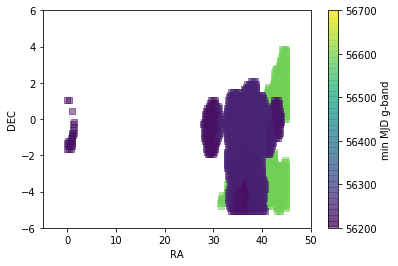

In [24]:
cm  = plt.cm.viridis
mjd  = data['features'][:, 19] # g band
mjdc = [56216, 56590, 56221, 56239, 56245]
radec= hpix2radec(256, data['hpix'])
for mask in mjdc:
    maski = (mjd >= mask) & (mjd < mask+6)  # bin size for nnbar study was ~ 5.4/5.7
    m = plt.scatter(radec[0][maski], radec[1][maski], 
                    c=mjd[maski], vmin=56200, vmax=56700, marker='s', alpha=0.5)
plt.axis([-5, 50, -6, 6])
plt.xlabel('RA');plt.ylabel('DEC')
cb = plt.colorbar()
cb.set_label('min MJD g-band')

In [3]:
r     = hp.read_map(scratch + 'eboss/eBOSS_DR7/random.256.fits', verbose=False)
g     = hp.read_map(scratch + 'eboss/eBOSS_DR7/eBOSSDR7.256.fits', verbose=False)
mask  = hp.read_map(scratch + 'eboss/eBOSS_DR7/hpmask.256.fits', verbose=False).astype('bool')
delta = np.zeros_like(r)*np.nan
avg   = g[mask].sum()/r[mask].sum()
delta[mask] = g[mask]/(r[mask]*avg) - 1

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


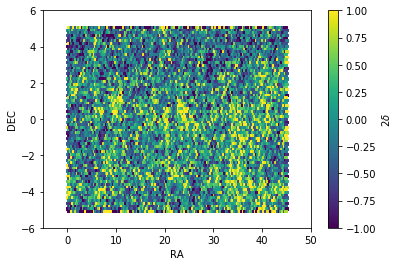

In [24]:
radec= hpix2radec(256, np.argwhere(mask).flatten())
plt.scatter(radec[0], radec[1], 5, c=2*delta[mask], vmin=-1, vmax=1., marker='s')
plt.axis([-5, 50, -6, 6])
plt.xlabel('RA');plt.ylabel('DEC')
cb = plt.colorbar()
cb.set_label(r'2$\delta$')

## clustering 
### N/Nbar vs. systematics
First we should run the `run_pipeline.py` code, and if required run `validate.py` to derive the NN weights

* Run the NN
* Run NNbar

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# d   = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22.npy').item()
# dw  = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22wnn.npy').item()
# dwd = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22wnnwdebv.npy').item()
# dl  = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22wlin.npy').item()

d   = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22_vs_mjd_now.npy').item()
dw  = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22_vs_mjd_nn.npy').item()
dwd = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22_vs_mjd_nnwdebv.npy').item()
# dl  = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/eboss22wlin.npy').item()

In [37]:
d['xlabels']

['hpgaiastardens',
 'hpebv',
 'hppsfdepth_r',
 'hppsfdepth_g',
 'hppsfdepth_z',
 'hpgaldepth_r',
 'hpgaldepth_g',
 'hpgaldepth_z',
 'hppsfsize_r',
 'hppsfsize_g',
 'hppsfsize_z',
 'hpnobs_r',
 'hpnobs_g',
 'hpnobs_z',
 'hpgaldepth_rg',
 'hpgaldepth_rz',
 'hpgaldepth_gz',
 'dE(B-V)',
 'mjd_r',
 'mjd_g',
 'mjd_z']

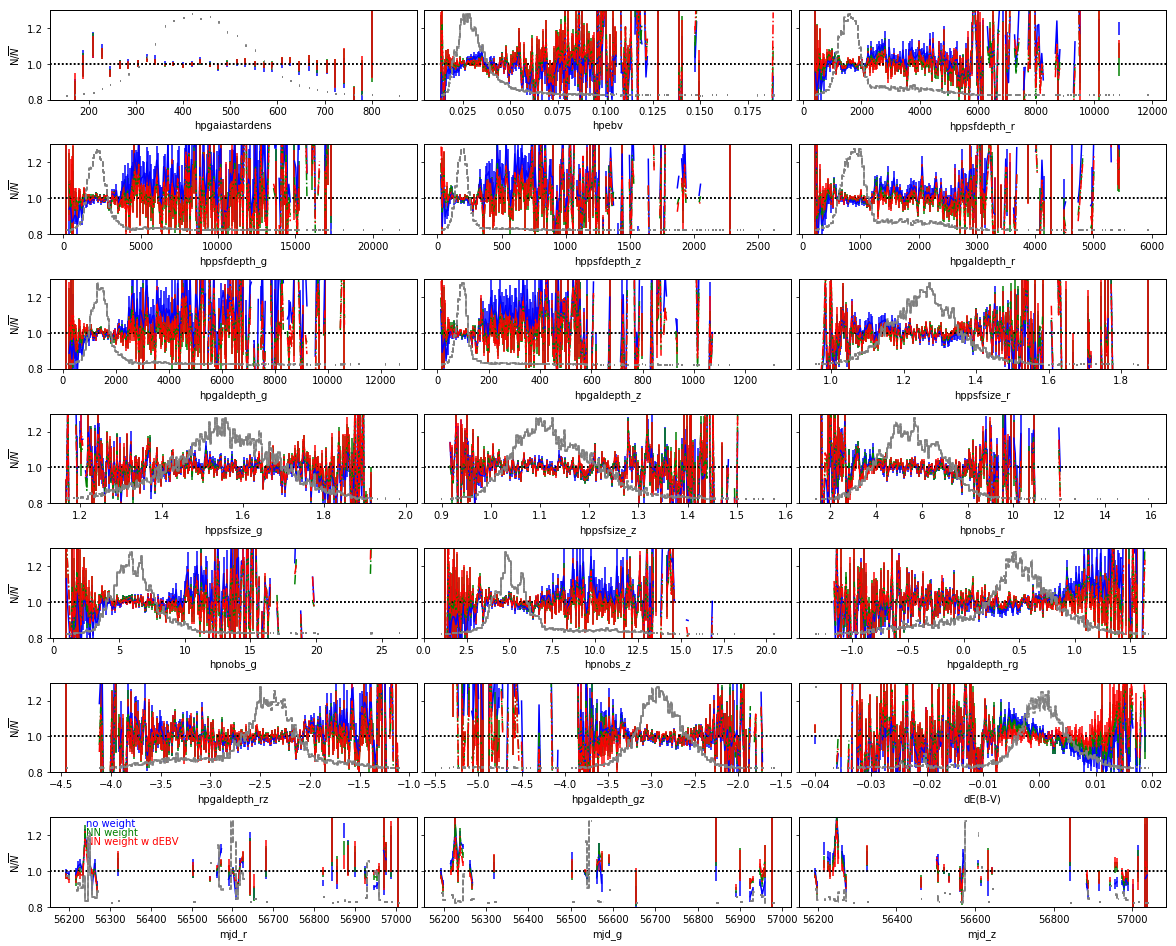

In [56]:
labels = d['xlabels']
fig, ax = plt.subplots(ncols=3, nrows=7, sharey=True, figsize=(20, 16.5)) # 10, 16.5
plt.subplots_adjust(wspace=0.02, hspace=0.5)
ax = ax.flatten()
# fig.delaxes(ax[-1])
def add_ax(ax, res, shift=1.0, **kw):
    ax.errorbar(res['bin_edges'][:-1]*shift, res['nnbar'],
                  yerr=res['nnbar_err'], **kw)
    ax.axhline(1, linestyle=':', color='k')
    ax2 = ax.twinx()
    ax2.set_yticks([])
    ax2.step(res['bin_edges'][:-1], res['area'],\
            where='post', linestyle='--', color='grey')

#
# compute nnbar vs. systematics
for i in range(len(d['xlabels'])):
    add_ax(ax[i], d['nnbar'][i], color='b', ls='-')
    add_ax(ax[i], dw['nnbar'][i], color='g', ls='-.')
    #add_ax(ax[i], dl['nnbar'][i], color='g', ls='--')
    add_ax(ax[i], dwd['nnbar'][i], color='r', ls='-.')
    if i%3 == 0:ax[i].set_ylabel(r'N/$\overline{N}$')
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylim(0.8, 1.3)
    if i==18:
        ax[i].text(0.1, 0.9, 'no weight', color='b', transform=ax[i].transAxes)
        ax[i].text(0.1, 0.8, 'NN weight', color='g', transform=ax[i].transAxes)
        ax[i].text(0.1, 0.7, 'NN weight w dEBV', color='r', transform=ax[i].transAxes)
plt.savefig('nnbar_eboss22.png', dpi=300, bbox_inches='tight')

Zoom into MJDs and figure out what part of the data is causing this issue

5.754973017064913
[56619 56239 56573 56872 56245]
5.754973017064913
[56619 56624 56872 56239 56245]
5.754973017064913
[56573 56619 56624 56245 56239]
5.754973017064913
[56216 56590 56221 56239 56245]
5.754973017064913
[56227 56567 56590 56239 56245]
5.754973017064913
[56227 56947 56239 56590 56245]
4.542278488952434
[56247 56215 56606 56252 56570]
4.542278488952434
[56261 56243 56247 56606 56252]
4.542278488952434
[56960 56606 56252 56502 56247]


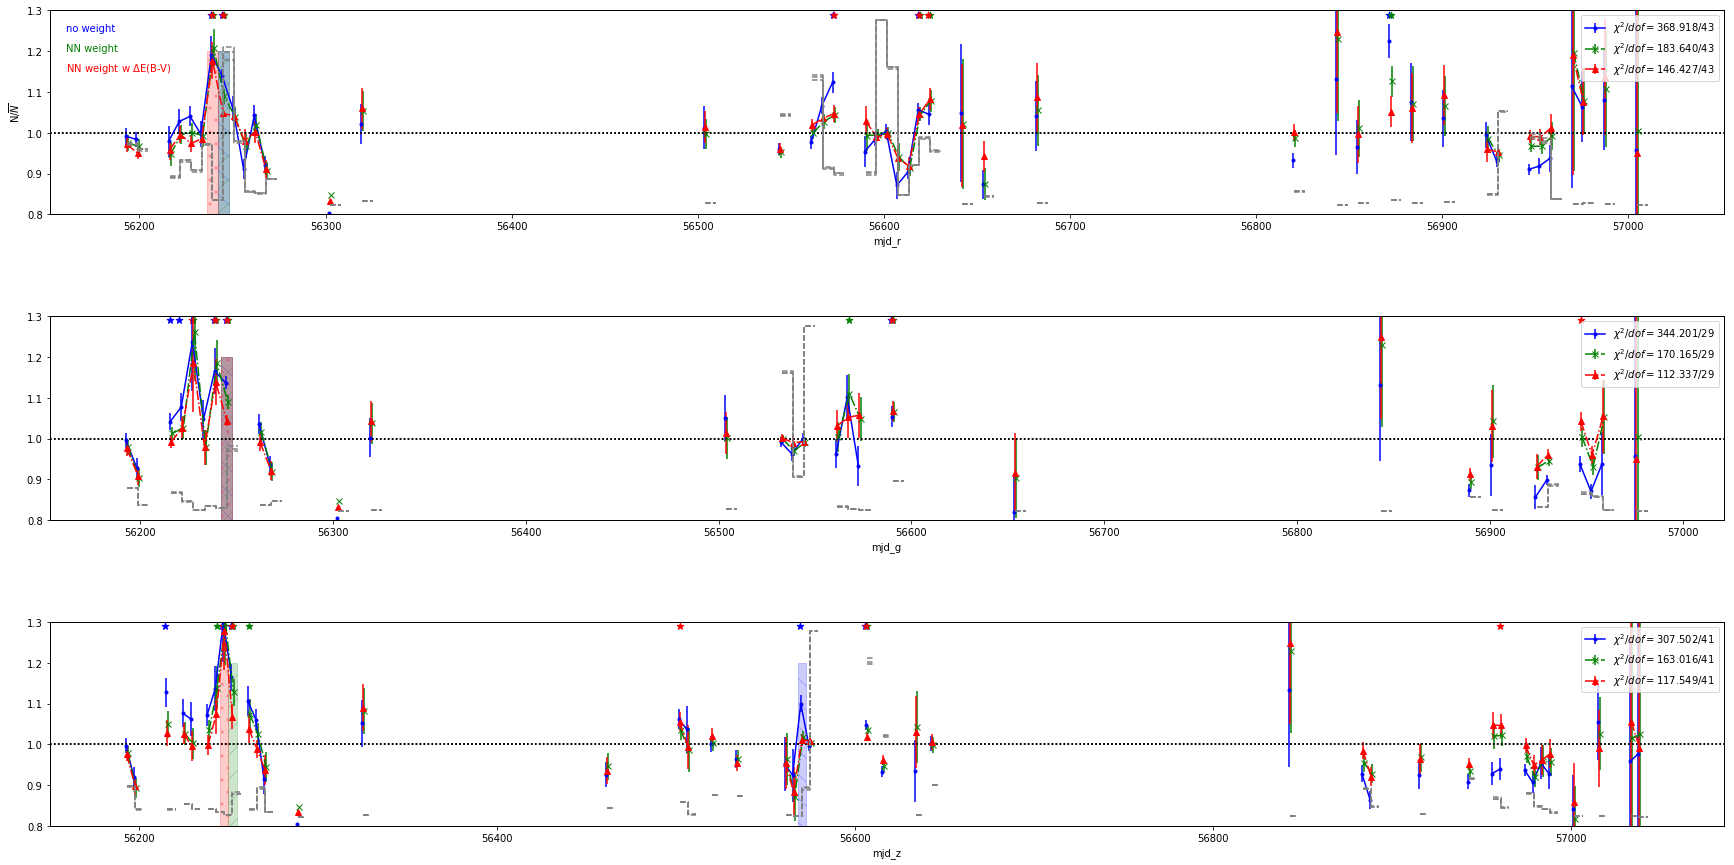

In [45]:
labels = d['xlabels']
fig, ax = plt.subplots(ncols=1, nrows=3, sharey=True, figsize=(30, 15)) # 10, 16.5
plt.subplots_adjust(wspace=0.02, hspace=0.5)
ax = ax.flatten()
def chi2 (x, y, ye): 
    dx = np.diff(x)[2]
    m = (~np.isnan(y)) & (~np.isnan(ye))
    terms = (y[m]-1.0)/ye[m]
    worst = x[m][np.argmax(terms)]
    temp  = np.zeros(terms.size, dtype=[('terms', type(terms)), ('mjd', type(x[m]))])
    temp['terms'] = terms
    temp['mjd']   = x[m]
    temps = np.sort(temp, order='terms')
    worsts= temps[-5:]['mjd'].astype('int')
    #print(terms.size, x.size, x[m].size)
    #print(temps[-5:])
    print(dx)
    return np.sum(terms**2), m.sum(), worst-dx/2., worst+dx/2., worsts
    
# fig.delaxes(ax[-1])
def add_ax(ax, res, shift=1.0, **kw):
    ci2, dof, wrst1, wrst2, worsts = chi2(res['bin_edges'][:-1], res['nnbar'], res['nnbar_err'])
    ax.fill_betweenx(x1=wrst1, x2=wrst2, y=[0.8, 1.2], alpha=0.2, color=kw['color'], hatch=kw['hatch'])
    ax.scatter(worsts*shift, 1.29*np.ones(worsts.size), 50., marker='*', color=kw['color'])
    #print('worst ', wrst1, wrst2-wrst1, res['bin_edges'][:3])
    kw.pop('hatch')
    ax.errorbar(res['bin_edges'][:-1]*shift, res['nnbar'],
                yerr=res['nnbar_err'], **kw, \
                label=r'$\chi^{}/dof={:.3f}/{}$'.format(2, ci2, dof))

    ax.axhline(1, linestyle=':', color='k')
    ax2 = ax.twinx()
    ax2.set_yticks([])
    ax2.step(res['bin_edges'][:-1], res['area'],\
            where='post', linestyle='--', color='grey')
    print(worsts)

#
# compute nnbar vs. systematics
for i,j in enumerate([18, 19, 20]):
    worsts = add_ax(ax[i], d['nnbar'][j], shift=0.99999, color='b', ls='-', marker='.', hatch='\\')
    worsts = add_ax(ax[i], dw['nnbar'][j],shift=1.00001, color='g', ls='-.', marker='x', hatch='/')
    #add_ax(ax[i], dl['nnbar'][i], color='g', ls='--')
    add_ax(ax[i], dwd['nnbar'][j], color='r', ls='-.', marker='^', hatch='.')
    print('==============================')
    if i%3 == 0:ax[i].set_ylabel(r'N/$\overline{N}$')
    ax[i].set_xlabel(labels[j])
    ax[i].set_ylim(0.8, 1.3)
    ax[i].legend(loc=1)
    if i==0:
        ax[i].text(0.01, 0.9, 'no weight', color='b', transform=ax[i].transAxes)
        ax[i].text(0.01, 0.8, 'NN weight', color='g', transform=ax[i].transAxes)
        ax[i].text(0.01, 0.7, r'NN weight w $\Delta$E(B-V)', color='r', transform=ax[i].transAxes)
plt.savefig('nnbar_eboss22.png', dpi=300, bbox_inches='tight')

### Angular clustering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

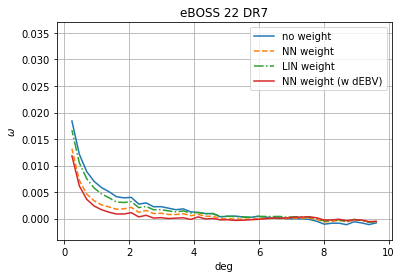

In [2]:
d = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering-dec27/ebossdr7xi_2pc_nside_256_njack_0.npy').item()
dw= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering-dec27/ebossdr7xi_2pc_wnn_nside_256_njack_0.npy').item()
dwd= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/ebossdr7xi_2pc_wnnwdebv_nside_256_njack_0.npy').item()
dl= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering-dec27/ebossdr7xi_2pc_wlin_nside_256_njack_0.npy').item()


l = ['no weight', 'NN weight', 'LIN weight', 'NN weight (w dEBV)'] 
ls=['-', '--', '-.', '-']
for i,di in enumerate([d, dw, dl, dwd]):
    plt.plot(np.degrees(di['t'][1:]), di['w'][0]/di['w'][1], label=l[i], ls=ls[i])
plt.xlabel('deg')
plt.ylabel(r'$\omega$')
plt.title('eBOSS 22 DR7')
plt.ylim(-0.004, 0.037)
plt.grid()
plt.legend()

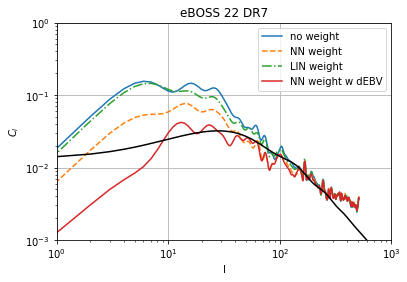

In [3]:
d = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering-dec27/cl_now.npy').item()
dw= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering-dec27/cl_nn.npy').item()
dwd= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/cl_nnwdebv.npy').item()
dl= np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering-dec27/cl_lin.npy').item()
lth, clth = np.loadtxt('/Users/rezaie/github/DESILSS/tests/lssdata/fftlog.out', usecols=(0,1), unpack=True)

l = ['no weight', 'NN weight', 'LIN weight', 'NN weight w dEBV'] 
ls=['-', '--', '-.', '-']
for i,di in enumerate([d, dw, dl, dwd]):
    plt.plot(np.arange(di['auto'].size), di['auto'], label=l[i], ls=ls[i])

plt.plot(lth, 1.e4*clth, 'k-')
plt.xlabel('l')
plt.ylabel(r'$C_{l}$')
plt.title('eBOSS 22 DR7')
# plt.ylim(-0.004, 0.037)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-3, 1)
plt.xlim(1, 1000)
plt.grid()
plt.legend()

Angular clustering of MJD masks

In [7]:
pcs = glob('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/ebossdr7xi_2pc*')
pcs

['/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/ebossdr7xi_2pc_uni_mjdg_gt_56750_nside_256_njack_0.npy',
 '/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/ebossdr7xi_2pc_uni_mjdg_lt_56400_nside_256_njack_0.npy',
 '/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/ebossdr7xi_2pc_uni_mjdg_lt_56750_gt_56400_nside_256_njack_0.npy',
 '/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering/ebossdr7xi_2pc_wnnwdebv_nside_256_njack_0.npy']

In [3]:
d = np.load('/Volumes/TimeMachine/data/eboss/eBOSS_DR7/clustering-dec27/ebossdr7xi_2pc_nside_256_njack_0.npy').item()

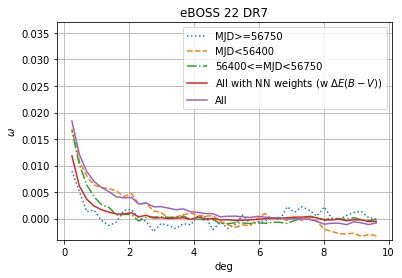

In [9]:
l = ['MJD>=56750', 'MJD<56400', '56400<=MJD<56750', r'All with NN weights (w $\Delta E(B-V)$)']
ls=[':','--','-.', '-']
for i,pcf in enumerate(pcs):
    di = np.load(pcf).item()
    plt.plot(np.degrees(di['t'][1:]), di['w'][0]/di['w'][1], label=l[i], ls=ls[i])
plt.plot(np.degrees(d['t'][1:]), d['w'][0]/d['w'][1], label='All')
plt.xlabel('deg')
plt.ylabel(r'$\omega$')
plt.title('eBOSS 22 DR7')
plt.ylim(-0.004, 0.037)
plt.grid()
plt.legend()